In [28]:
!pip install -U spacy
!python -m spacy download en_core_web_md

  Using cached numpy-2.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.0.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
langchain 0.3.7 requires numpy<2,>=1; python_version < "3.12", but you have numpy 2.0.2 which is incompatible.
matplotlib 3.8.0 requires numpy<2,>=1.21, but you have numpy 2.0.2 which is incompatible.
pytensor 2.26.3 requires numpy<2,>=1.17.0, but you have numpy 2.0.2 which is incompatible.

In [29]:
!pip install pandas
!pip install matplotlib


  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blis 1.0.1 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [30]:
pip install langdetect googletrans==4.0.0-rc1

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from langdetect import detect
import re
import ast
from sklearn.preprocessing import LabelEncoder

In [32]:
#------------------------------
#import file with google colab from google drive
#------------------------------
from google.colab import drive
drive.mount("/content/drive")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test.csv")
df_test_label = pd.read_csv("/content/drive/MyDrive/test_labels.csv")
df_sample_submission = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")

In [ ]:
#------------------------------
#import file local
#------------------------------

df_train = pd.read_csv("./dataset/natif/train.csv")
df_test = pd.read_csv("./dataset/natif/test.csv")
df_test_label = pd.read_csv("./dataset/natif/test_labels.csv")
df_sample_submission = pd.read_csv("./dataset/natif/sample_submission.csv")



In [ ]:
def remove_non_english_rows(df, column_name):
    """
    Supprime toutes les lignes où la colonne spécifiée contient du texte dans une langue autre que l'anglais.

    Args:
        df (pd.DataFrame): Le DataFrame contenant la colonne à vérifier.
        column_name (str): Le nom de la colonne contenant les phrases à analyser.

    Returns:
        pd.DataFrame: Un DataFrame contenant uniquement les lignes où les phrases sont en anglais.
    """
    def is_english(text):
        try:
            # Vérifier si le texte est valide
            if not isinstance(text, str) or not text.strip():
                return False  # Considérer les non-textes ou les vides comme non-anglais
            # Détecter la langue
            return detect(text) == 'en'
        except Exception as e:
            # En cas d'erreur, considérer comme non-anglais
            return False

    # Appliquer la fonction par lots pour éviter les surcharges mémoire
    df = df.copy()
    df['is_english'] = df[column_name].map(is_english)  # Ajout d'une colonne temporaire
    df = df[df['is_english']].drop(columns=['is_english'])  # Filtrer et supprimer la colonne temporaire

    return df

print(f"Nombre de lignes train avant suppression: {len(df_train)}")
print(f"Nombre de lignes test avant suppression: {len(df_test)}")


df_train = remove_non_english_rows(df_train, 'comment_text')
df_test = remove_non_english_rows(df_test, 'comment_text')

print(f"Nombre de lignes train après suppression: {len(df_train)}")
print(f"Nombre de lignes test après suppression: {len(df_test)}")


Nombre de lignes train avant suppression: 159571
Nombre de lignes test avant suppression: 153164


KeyboardInterrupt: 

In [ ]:
df_train.to_csv("/content/drive/MyDrive/train_englishonly.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/test_englishonly.csv", index=False)

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/train_englishonly.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test_englishonly.csv")

In [ ]:
print(f"Nombre de lignes train après suppression: {len(df_train)}")
print(f"Nombre de lignes test après suppression: {len(df_test)}")

print(df_train.shape)
print(df_test.shape)

print((df_train['toxic'] == 1).sum())
print((df_train['toxic'] == 0).sum())

Nombre de lignes train après suppression: 155267
Nombre de lignes test après suppression: 142783
(155267, 8)
(142783, 2)
14202
141065


In [ ]:
import pandas as pd

def split_test_into_train_and_validation(df_train, df_test):
    """
    Répartit le DataFrame de test :
    - La moitié est ajoutée au DataFrame d'entraînement.
    - La moitié restante est divisée en deux pour créer un DataFrame de validation et un DataFrame de test.

    Args:
        df_train (pd.DataFrame): Le DataFrame d'entraînement initial.
        df_test (pd.DataFrame): Le DataFrame de test initial.

    Returns:
        pd.DataFrame, pd.DataFrame, pd.DataFrame: Les nouveaux DataFrames pour l'entraînement, la validation, et le test.
    """
    # Mélanger les données pour garantir un bon mélange
    df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

    # Diviser en deux moitiés
    split_index = len(df_test) // 2
    test_to_train = df_test.iloc[:split_index]
    remaining_test = df_test.iloc[split_index:]

    # Ajouter une partie au DataFrame d'entraînement
    df_train = pd.concat([df_train, test_to_train]).reset_index(drop=True)

    # Diviser la partie restante en validation et test
    split_index_validation = len(remaining_test) // 2
    df_validation = remaining_test.iloc[:split_index_validation]
    df_test = remaining_test.iloc[split_index_validation:]

    return df_train, df_validation, df_test

#relier test et test_label
df_test = pd.merge(df_test, df_test_label, on='id')

df_train, df_validation, df_test = split_test_into_train_and_validation(df_train, df_test)

In [ ]:
print(df_train.shape)
print(df_validation.shape)
print(df_test.shape)

print((df_train.columns))

print((df_train['toxic'] == 1).sum())
print((df_train['toxic'] == 0).sum())

(226658, 8)
(35696, 8)
(35696, 8)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
16966
168354


In [ ]:


#équilibrage des classes toxic, non toxic
print("Train before: ", df_train.shape)

#sous échantillonage df_train pour avoir 30000 lignes non toxiques
df_train_non_toxic = df_train[df_train['toxic'] == 0].sample(33000)
df_train_toxic = df_train[df_train['toxic'] == 1]
df_train = pd.concat([df_train_non_toxic, df_train_toxic])

#supprimer les lignes de df_test comprenant des -1 dans la partie toxic
df_test = df_test[df_test['toxic'] != -1]
df_validation = df_validation[df_validation['toxic'] != -1]


#afficher le nombre de lignes et de colonnes
print("Train after: ", df_train.shape)



Train before:  (226658, 8)
Train after:  (49966, 8)


In [ ]:
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(49966, 8)
(14988, 8)
(14882, 8)


In [ ]:
df_train.to_csv("/content/drive/MyDrive/train_balanced.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/test_balanced.csv", index=False)
df_validation.to_csv("/content/drive/MyDrive/validation_balanced.csv", index=False)

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/train_balanced.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test_balanced.csv")
df_validation = pd.read_csv("/content/drive/MyDrive/validation_balanced.csv")

In [ ]:
#preprocess

#spacy preprocessing
nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])

def preprocess_text(text):
    """
    Prétraite un texte en utilisant spaCy :
    - Supprime les sauts de ligne (\n) et les caractères '='.
    - Tokenise et lemmatise.
    - Conserve les points d'exclamation (!) et d'interrogation (?).
    - Supprime les autres signes de ponctuation.

    Args:
        text (str): Le texte brut à traiter.

    Returns:
        list: Une liste de tokens nettoyés.
    """
    # Supprimer les caractères spécifiques comme '\n' et '='
    cleaned_text = text.replace('\n', ' ').replace('=', '').replace('\r','')

    # Tokeniser avec spaCy
    doc = nlp(cleaned_text)


    # Conserver les tokens voulus
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_punct or token.text in {'!', '?'}
    ]

    return tokens

df_train['comment_text_tokenized_sw'] = df_train['comment_text'].apply(preprocess_text)

df_test['comment_text_tokenized_sw'] = df_test['comment_text'].apply(preprocess_text)

df_validation['comment_text_tokenized_sw'] = df_validation['comment_text'].apply(preprocess_text)

In [ ]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_tokenized_sw
0,27bd9cb332e0c136,"Received \r\n\r\nThanks a lot Carlo, I really ...",0,0,0,0,0,0,"[receive, , thank, a, lot, carlo, i, really,..."
1,cb2a8ada1a89b925,""" \r\n\r\n I added most of the content to this...",0,0,0,0,0,0,"[ , i, add, most, of, the, content, to, this..."
2,ffcc31381cad777a,""" \r\n\r\n \r\n == Merging with """"Impact of t...",0,0,0,0,0,0,"[ , merge, with, impact, of, technology,..."
3,fd35f5d8c1556e56,"""\r\n\r\nIt all depends on what you call free ...",0,0,0,0,0,0,"[ , it, all, depend, on, what, you, call, free..."
4,63712bc8fbfc90ab,So while I'll concede (if more experienced mat...,0,0,0,0,0,0,"[so, while, i, will, concede, if, more, experi..."


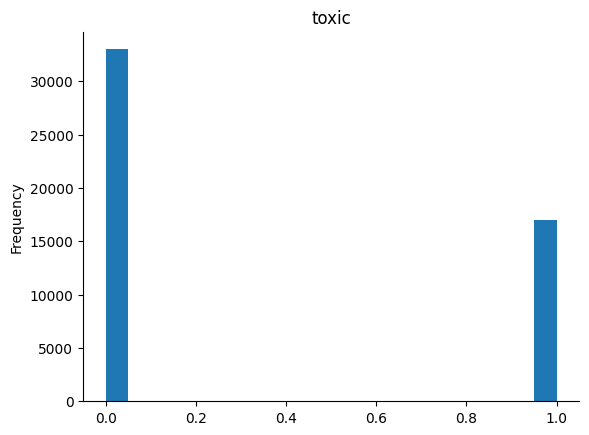

In [ ]:
# @title toxic

from matplotlib import pyplot as plt
df_train['toxic'].plot(kind='hist', bins=20, title='toxic')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [61]:
#transformation des tokens du dataframe en list
df_train['comment_text_tokenized_sw'] = df_train['comment_text_tokenized_sw'].apply(ast.literal_eval)
df_test['comment_text_tokenized_sw'] = df_test['comment_text_tokenized_sw'].apply(ast.literal_eval)
df_validation['comment_text_tokenized_sw'] = df_validation['comment_text_tokenized_sw'].apply(ast.literal_eval)

In [63]:

#supprime les tokens vide
df_train["comment_text_tokenized_sw"] = df_train["comment_text_tokenized_sw"].apply(
    lambda tokens: [token for token in tokens if token.strip()]
)

df_validation["comment_text_tokenized_sw"] = df_validation["comment_text_tokenized_sw"].apply(
    lambda tokens: [token for token in tokens if token.strip()]
)

df_test["comment_text_tokenized_sw"] = df_test["comment_text_tokenized_sw"].apply(
    lambda tokens: [token for token in tokens if token.strip()]
)

In [64]:
#suppression des tokens contenant des liens
def remove_links(df, column_name):
    url_pattern = re.compile(r'http[s]?://|www\.')
    df[column_name] = df[column_name].apply(lambda tokens: [token for token in tokens if not re.match(url_pattern, token)])

    return df

df_train = remove_links(df_train, "comment_text_tokenized_sw")
df_test = remove_links(df_test, "comment_text_tokenized_sw")
df_validation = remove_links(df_validation, "comment_text_tokenized_sw")

In [ ]:

def remplacer_mots_par_num(phrase):
    return ['num' if any(char.isdigit() for char in mot) else mot for mot in phrase]


#conversion en liste et remplacement de chaques tokens contenant des chiffre en "num"

df_train["comment_text_tokenized_sw"] = df_train["comment_text_tokenized_sw"].apply(remplacer_mots_par_num)


df_test["comment_text_tokenized_sw"] = df_test["comment_text_tokenized_sw"].apply(remplacer_mots_par_num)


df_validation["comment_text_tokenized_sw"] = df_validation["comment_text_tokenized_sw"].apply(remplacer_mots_par_num)



In [66]:
def clean_tokens(df, column_name):
    """
    Nettoie les tokens d'une colonne tokenisée dans un DataFrame.
    Supprime les caractères indésirables au début et à la fin de chaque token
    (comme ", @, -).

    Paramètres :
    - df (pd.DataFrame) : Le DataFrame contenant la colonne à traiter.
    - column_name (str) : Le nom de la colonne contenant les listes de tokens.

    Retourne :
    - Le DataFrame avec la colonne modifiée (tokens nettoyés).
    """
    # Fonction pour nettoyer un token
    def clean_token(token):
        # Supprimer les caractères non-alphanumériques au début et à la fin
        return re.sub(r'^[^a-zA-Z0-9]+|[^a-zA-Z0-9]+$', '', token)

    # Appliquer la fonction de nettoyage à chaque token de la colonne
    df[column_name] = df[column_name].apply(
        lambda tokens: [clean_token(token) for token in tokens if clean_token(token)]  # Nettoie et enlève les tokens vides
    )

    return df

df_train = clean_tokens(df_train, "comment_text_tokenized_sw")
df_test = clean_tokens(df_test, "comment_text_tokenized_sw")
df_validation = clean_tokens(df_validation, "comment_text_tokenized_sw")


In [67]:
nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])
def remove_stop_word(df, token_column):
    #Supprime les stop words d'une colonne contenant des listes de tokens.

    def remove_stopwords(tokens):
        return [token for token in tokens if not nlp.vocab[token].is_stop]

    # Appliquer la suppression des stop words sur la colonne spécifiée
    return df[token_column].apply(remove_stopwords)

# dans la colonne comment_text_tokenized, supprimer les stopword de la colonne comment_text_tokenized_sw
df_train['comment_text_tokenized'] = remove_stop_word(df_train, 'comment_text_tokenized_sw')
df_test['comment_text_tokenized'] = remove_stop_word(df_test, 'comment_text_tokenized_sw')
df_validation['comment_text_tokenized'] = remove_stop_word(df_validation, 'comment_text_tokenized_sw')

In [68]:
df_train.to_csv("/content/drive/MyDrive/train_preprocessed.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/test_preprocessed.csv", index=False)
df_validation.to_csv("/content/drive/MyDrive/validation_preprocessed.csv", index=False)

In [59]:
df_train = pd.read_csv("/content/drive/MyDrive/train_preprocessed.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test_preprocessed.csv")
df_validation = pd.read_csv("/content/drive/MyDrive/validation_preprocessed.csv")

In [69]:
def get_dico(dataframe, column_name):
    """
    Crée un DataFrame dictionnaire à partir des mots tokenisés dans une colonne d'un DataFrame.

    Args:
        dataframe (pd.DataFrame): Le DataFrame contenant la colonne de mots tokenisés.
        column_name (str): Le nom de la colonne contenant les listes de mots tokenisés.

    Returns:
        pd.DataFrame: Un DataFrame avec deux colonnes : 'word' et 'id'.
    """
    # Vérification que la colonne contient des listes de mots
    if not all(isinstance(row, list) for row in dataframe[column_name]):
        raise ValueError("La colonne spécifiée doit contenir des listes de mots tokenisés.")

    # Extraire tous les mots tokenisés et créer un ensemble unique
    all_tokens = [word for tokens in dataframe[column_name] for word in tokens]
    unique_words = sorted(set(all_tokens))  # Tri des mots pour cohérence

    # Créer un DataFrame avec les mots et leurs indices
    dico_df = pd.DataFrame({'word': unique_words, 'id': range(len(unique_words))})
    return dico_df



df_dico = get_dico(df_train, "comment_text_tokenized_sw")

print(df_dico.head())

      word  id
0        a   0
1     a$$e   1
2  a$$hole   2
3  a%%hole   3
4      a&e   4


In [70]:
def convert_with_dico(dataframe, column_name, dico_df):
    """
    Convertit les mots tokenisés dans une colonne d'un DataFrame en leurs IDs
    selon un DataFrame dictionnaire.

    Args:
        dataframe (pd.DataFrame): Le DataFrame contenant la colonne de mots tokenisés.
        column_name (str): Le nom de la colonne contenant les listes de mots tokenisés.
        dico_df (pd.DataFrame): Le DataFrame contenant les colonnes 'word' et 'id'.

    Returns:
        pd.DataFrame: Une copie du DataFrame avec les mots convertis en IDs dans la colonne spécifiée.
    """
    # Création d'un mapping mot -> ID à partir du DataFrame dictionnaire
    word_to_id = pd.Series(dico_df['id'].values, index=dico_df['word']).to_dict()

    dataframe = dataframe.copy()
    dataframe[column_name + "numbered"] = dataframe[column_name].apply(
        lambda tokens: [word_to_id.get(word, -1) for word in tokens]  # -1 pour les mots non trouvés
    )
    return dataframe


df_train = convert_with_dico(df_train, "comment_text_tokenized_sw", df_dico)
df_test = convert_with_dico(df_test, "comment_text_tokenized_sw", df_dico)
df_validation = convert_with_dico(df_validation, "comment_text_tokenized_sw", df_dico)


df_train = convert_with_dico(df_train, "comment_text_tokenized", df_dico)
df_test = convert_with_dico(df_test, "comment_text_tokenized", df_dico)
df_validation = convert_with_dico(df_validation, "comment_text_tokenized", df_dico)

In [71]:
df_dico


,word,id
0,a,0
1,a$$e,1
2,a$$hole,2
3,a%%hole,3
4,a&e,4
...,...,...
75926,zzzzzzzzzzzzzzzzz,75926
75927,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...,75927
75928,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...,75928
75929,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...,75929


In [72]:
df_validation.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_tokenized_sw,comment_text_tokenized,comment_text_tokenized_swnumbered,comment_text_tokenizednumbered
0,f7dee2f5b8df6990,:::Yes - nr. 1 is about Antarctica. nr. 2 is a...,0,0,0,0,0,0,"[yes, nr, num, be, about, antarctica, nr, num,...","[yes, nr, num, antarctica, nr, num, kyoto, que...","[75112, 46464, 46573, 6311, 272, 3041, 46464, ...","[75112, 46464, 46573, 3041, 46464, 46573, 3725..."
1,68f58fd4c7a59f64,Support As above. I feel it's the right time t...,0,0,0,0,0,0,"[support, as, above, i, feel, it, be, the, rig...","[support, feel, right, time]","[64496, 4185, 283, 31369, 23610, 34048, 6311, ...","[64496, 23610, 56503, 67105]"
2,71065b3c02b26d19,"I thought that if your mother is Jewish, you a...",0,0,0,0,0,0,"[i, think, that, if, your, mother, be, jewish,...","[think, mother, jewish, jewish, matter]","[31369, 66688, 66366, 31693, 75359, 43613, 631...","[66688, 43613, 34803, 34803, 41018]"
3,62be8dc617034d73,""" \r\n\r\n ==Scope of article and what could w...",0,0,0,0,0,0,"[scope, of, article, and, what, could, we, inc...","[scope, article, include, table, right, includ...","[58734, 47113, 4069, 2665, 73089, 14520, 72702...","[58734, 4069, 32404, 65110, 56503, 32404, 4418..."
4,c2d8b6f9aee16f29,""" \r\n\r\n I suck at reading directions, don'...",0,0,0,0,0,0,"[i, suck, at, read, direction, do, not, i, ed]","[suck, read, direction, ed]","[31369, 64119, 4597, 54497, 18002, 18704, 4624...","[64119, 54497, 18002, 20163]"


In [73]:
df_train.to_csv("/content/drive/MyDrive/train_preprocessed.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/test_preprocessed.csv", index=False)
df_validation.to_csv("/content/drive/MyDrive/validation_preprocessed.csv", index=False)
df_dico.to_csv("/content/drive/MyDrive/dico.csv", index=False)